<a href="https://colab.research.google.com/github/tejasr112002/ConvLab-2/blob/master/TGIFHacks_125_Cryptocurrency_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install alpha_vantage

     |████████████████████████████████| 1.3 MB 29.9 MB/s 
     |████████████████████████████████| 142 kB 62.0 MB/s 
     |████████████████████████████████| 294 kB 59.0 MB/s 


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from alpha_vantage.cryptocurrencies import CryptoCurrencies

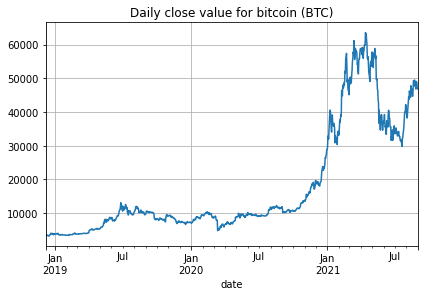

In [3]:
cc = CryptoCurrencies(key='QF4VJRW3HTAIC4YA', output_format='pandas')
crypto_data, meta_data = cc.get_digital_currency_daily(symbol='BTC', market='CNY')
crypto_data['4b. close (USD)'].plot()
plt.tight_layout()
plt.title('Daily close value for bitcoin (BTC)')
plt.grid()
plt.show()

In [64]:
crypto_data


,1a. open (CNY),1b. open (USD),2a. high (CNY),2b. high (USD),3a. low (CNY),3b. low (USD),4a. close (CNY),4b. close (USD),5. volume,6. market cap (USD)
date,,,,,,,,,,
2021-08-31,303838.47897,46982.91,304859.48893,47140.79,302008.90000,46700.00,303109.06604,46870.12,2620.934600,2620.934600
2021-08-30,315381.62128,48767.84,316162.64087,48888.61,302998.35100,46853.00,303838.47897,46982.91,40288.350830,40288.350830
2021-08-29,316206.22845,48895.35,320971.89009,49632.27,308880.34618,47762.54,315381.55661,48767.83,32652.283473,32652.283473
2021-08-28,317335.04330,49069.90,318816.63300,49299.00,312659.27296,48346.88,316206.22845,48895.35,26681.063786,26681.063786
2021-08-27,302939.24262,46843.86,317852.59731,49149.93,299732.51600,46348.00,317335.04330,49069.90,42068.104965,42068.104965
...,...,...,...,...,...,...,...,...,...,...
2018-12-10,22948.08483,3548.49,23345.87000,3610.00,21794.50137,3370.11,22200.43496,3432.88,40989.244553,40989.244553
2018-12-09,22061.26512,3411.36,23656.28600,3658.00,21949.25668,3394.04,22927.90779,3545.37,45956.893296,45956.893296
2018-12-08,22010.88719,3403.57,22602.16500,3495.00,20836.67400,3222.00,22058.48431,3410.93,55365.949949,55365.949949


In [5]:
crypto_df = crypto_data["4b. close (USD)"]
crypto_df

date
2021-08-31    46870.12
2021-08-30    46982.91
2021-08-29    48767.83
2021-08-28    48895.35
2021-08-27    49069.90
                ...   
2018-12-10     3432.88
2018-12-09     3545.37
2018-12-08     3410.93
2018-12-07     3403.55
2018-12-06     3508.75
Name: 4b. close (USD), Length: 1000, dtype: float64

In [6]:
crypto_df.describe()

count     1000.000000
mean     17628.726990
std      16259.974775
min       3211.720000
25%       7541.085000
50%       9795.995000
75%      24044.325000
max      63575.000000
Name: 4b. close (USD), dtype: float64

In [7]:
bitcoin_ordered_df = crypto_df.loc[::-1]

In [8]:
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, Flatten
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.layers import ConvLSTM2D
from keras.callbacks import EarlyStopping
import datetime
from keras.preprocessing.sequence import TimeseriesGenerator
import numpy

In [9]:
dataset=bitcoin_ordered_df.values
#dataset.reshape(-1, 1)
dataset=dataset.astype('float32')
dataset = np.reshape(dataset,(dataset.size,1))

In [10]:
scaler=MinMaxScaler(feature_range=(0,1))
dataset=scaler.fit_transform(dataset)

The train and test data will contain two-thirds and one-third of the dataset respectively.

In [11]:
train_size=int(len(dataset)*0.66)
test_size=len(dataset)-train_size
train,test = dataset[0:train_size],dataset[train_size:] #Splitting the dataset into test and train

In [12]:
print("Train Size:",train_size)
print("Test Size",test_size)

Train Size: 660
Test Size 340


The **to_sequences** method creates a dataset where X is the closing value of the cryptocurrency at a given time **(t, t-1, t-2...)** 
and Y is the closing value at the next time **(t + 1)**. Where **seq_size** is the number of previous time steps to use as input variables to predict the next time period.

In [13]:
def to_sequences(dataset, seq_size=1):
    x = []
    y = []

    for i in range(len(dataset)-seq_size-1):
        window = dataset[i:(i+seq_size), 0]
        x.append(window)
        y.append(dataset[i+seq_size, 0])
        
    return np.array(x),np.array(y)

In [14]:
seq_size = 10  # Number of time steps to look back 
#Larger sequences (look further back) may improve forecasting.

trainX, trainY = to_sequences(train, seq_size)
testX, testY = to_sequences(test, seq_size)

print("Shape of training set: {}".format(trainX.shape))
print("Shape of test set: {}".format(testX.shape))

Shape of training set: (649, 10)
Shape of test set: (329, 10)


In [15]:
trainX.shape[0]

649

In [16]:
#Convolutional univariate LSTM
#The shape of input data must be: [samples, timesteps, rows, columns, features]

trainX = trainX.reshape((trainX.shape[0], 1, 1, 1, seq_size))
testX = testX.reshape((testX.shape[0], 1, 1, 1, seq_size))

model = Sequential()
model.add(ConvLSTM2D(filters=64, kernel_size=(1,1), activation='relu', input_shape=(1, 1, 1, seq_size)))
model.add(Flatten())
model.add(Dense(32))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()


array([[[[[0.00492071, 0.00317793, 0.00330018, ..., 0.00149661,
           0.00020625, 0.        ]]]],



       [[[[0.00317793, 0.00330018, 0.00552737, ..., 0.00020625,
           0.        , 0.0002808 ]]]],



       [[[[0.00330018, 0.00552737, 0.00366381, ..., 0.        ,
           0.0002808 , 0.00492617]]]],



       ...,



       [[[[0.11976154, 0.11797088, 0.12358588, ..., 0.13035955,
           0.1277028 , 0.11936891]]]],



       [[[[0.11797088, 0.12358588, 0.12546682, ..., 0.1277028 ,
           0.11936891, 0.12123083]]]],



       [[[[0.12358588, 0.12546682, 0.12826158, ..., 0.11936891,
           0.12123083, 0.11645722]]]]], dtype=float32)

In [19]:
model.fit(trainX, trainY, validation_data=(testX, testY),
          verbose=2, epochs=100)

Epoch 1/100
21/21 - 3s - loss: 0.0027 - val_loss: 0.1449
Epoch 2/100
21/21 - 0s - loss: 7.8923e-04 - val_loss: 0.0863
Epoch 3/100
21/21 - 0s - loss: 2.6222e-04 - val_loss: 0.0172
Epoch 4/100
21/21 - 0s - loss: 8.7954e-05 - val_loss: 0.0083
Epoch 5/100
21/21 - 0s - loss: 8.4823e-05 - val_loss: 0.0106
Epoch 6/100
21/21 - 0s - loss: 8.1804e-05 - val_loss: 0.0097
Epoch 7/100
21/21 - 0s - loss: 7.5261e-05 - val_loss: 0.0099
Epoch 8/100
21/21 - 0s - loss: 7.2213e-05 - val_loss: 0.0095
Epoch 9/100
21/21 - 0s - loss: 7.0044e-05 - val_loss: 0.0092
Epoch 10/100
21/21 - 0s - loss: 7.1660e-05 - val_loss: 0.0101
Epoch 11/100
21/21 - 0s - loss: 6.9740e-05 - val_loss: 0.0080
Epoch 12/100
21/21 - 0s - loss: 6.1184e-05 - val_loss: 0.0088
Epoch 13/100
21/21 - 0s - loss: 6.4721e-05 - val_loss: 0.0084
Epoch 14/100
21/21 - 0s - loss: 6.0032e-05 - val_loss: 0.0089
Epoch 15/100
21/21 - 0s - loss: 5.8557e-05 - val_loss: 0.0074
Epoch 16/100
21/21 - 0s - loss: 5.3423e-05 - val_loss: 0.0066
Epoch 17/100
21/21 - 

In [20]:
#Making predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
testPredict

array([[0.12422174],
       [0.12295102],
       [0.12311569],
       [0.12645985],
       [0.12879248],
       [0.13199243],
       [0.13414158],
       [0.13618806],
       [0.13589771],
       [0.13545936],
       [0.1357152 ],
       [0.13386068],
       [0.1335217 ],
       [0.1351957 ],
       [0.13865714],
       [0.14138174],
       [0.15081549],
       [0.15529376],
       [0.15512258],
       [0.15627185],
       [0.15670323],
       [0.1565739 ],
       [0.16138467],
       [0.16085437],
       [0.16203122],
       [0.16413835],
       [0.16624862],
       [0.16688126],
       [0.1653058 ],
       [0.16843346],
       [0.17070208],
       [0.18070635],
       [0.1857244 ],
       [0.18039696],
       [0.18202692],
       [0.18397754],
       [0.18407947],
       [0.18666014],
       [0.19373637],
       [0.19641176],
       [0.194169  ],
       [0.193174  ],
       [0.19769526],
       [0.2071397 ],
       [0.2113508 ],
       [0.21203807],
       [0.21793672],
       [0.221

We must invert the prediction back to prescaled values in order to compare them with the original input values. Since we used **MinMaxScaler** to **normalize** the original values, we can now use **scaler.inverse_transform** to **reverse the tranformation**(normalization).

In [21]:
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [22]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))

testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 324.73 RMSE
Test Score: 6099.08 RMSE


plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

In [23]:
#Shift train predictions for plotting
#We must shift the predictions so that they align on the x-axis with the original dataset. 
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[seq_size:len(trainPredict)+seq_size, :] = trainPredict

# Shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(seq_size*2)+1:len(dataset)-1, :] = testPredict

In [24]:
dates_ind=[]
for i in range(999,0,-100):
  dates_ind.append(i)
dates_ind.append(0)

dates=[]

for i in dates_ind:
  dates.append(crypto_data.iloc[i].name.date())
dates

[datetime.date(2018, 12, 6),
 datetime.date(2019, 3, 16),
 datetime.date(2019, 6, 24),
 datetime.date(2019, 10, 2),
 datetime.date(2020, 1, 10),
 datetime.date(2020, 4, 19),
 datetime.date(2020, 7, 28),
 datetime.date(2020, 11, 5),
 datetime.date(2021, 2, 13),
 datetime.date(2021, 5, 24),
 datetime.date(2021, 8, 31)]

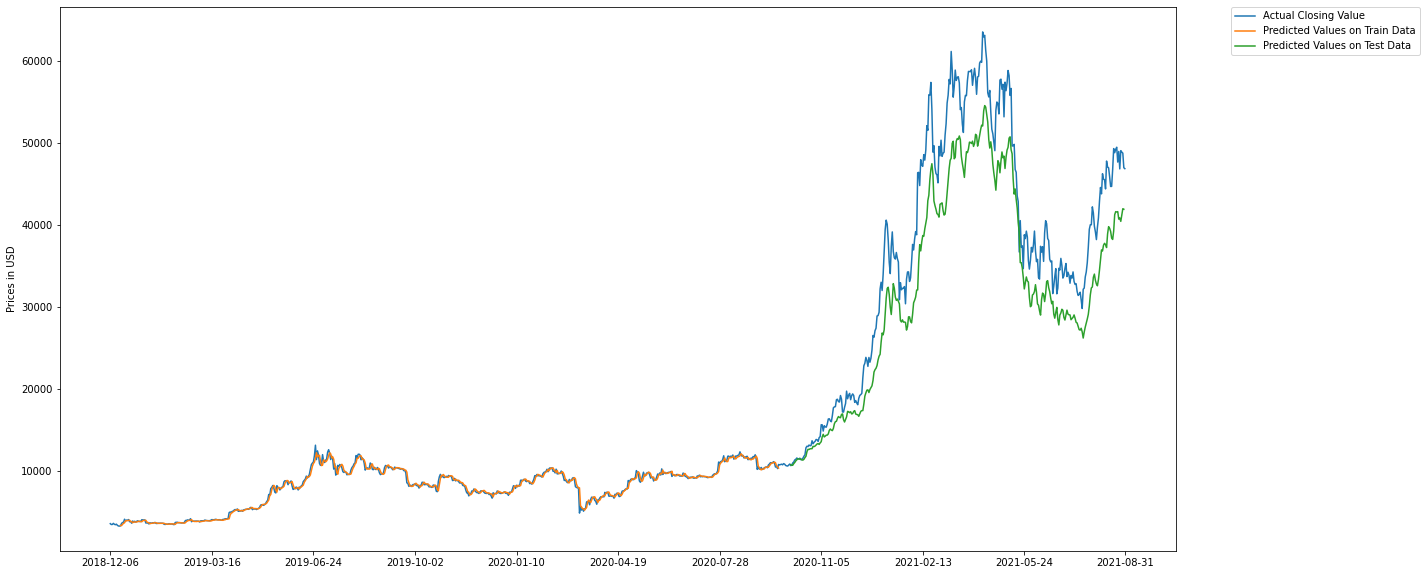

In [25]:


# plot baseline and predictions
fig, ax = plt.subplots(figsize=(20, 10))

plt.plot(scaler.inverse_transform(dataset), label="Actual Closing Value")
plt.plot(trainPredictPlot, label="Predicted Values on Train Data")
plt.plot(testPredictPlot, label="Predicted Values on Test Data")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.ylabel('Prices in USD')
  
plt.xticks([0,100, 200, 300, 400, 500, 600, 700, 800, 900, 999],dates)
plt.show()

In [54]:
scaler.inverse_transform(dataset[-20:])

array([[44399.  ],
       [47800.  ],
       [47068.51],
       [46973.82],
       [45901.29],
       [44695.95],
       [44705.29],
       [46760.62],
       [49322.47],
       [48821.87],
       [49239.22],
       [49488.85],
       [47674.01],
       [48973.32],
       [46843.87],
       [49069.9 ],
       [48895.35],
       [48767.83],
       [46982.91],
       [46870.12]], dtype=float32)

In [62]:
x_input = dataset[-50:]
x_pred, y_pred = to_sequences(x_input,10)
x_pred = x_pred.reshape(x_pred.shape[0],1,1,1,10)
x_pred

array([[[[[0.4890067 , 0.49050182, 0.47492915, 0.46671003, 0.46896642,
           0.47324866, 0.4576943 , 0.4403112 , 0.4793111 , 0.4816854 ]]]],



       [[[[0.49050182, 0.47492915, 0.46671003, 0.46896642, 0.47324866,
           0.4576943 , 0.4403112 , 0.4793111 , 0.4816854 , 0.503988  ]]]],



       [[[[0.47492915, 0.46671003, 0.46896642, 0.47324866, 0.4576943 ,
           0.4403112 , 0.4793111 , 0.4816854 , 0.503988  , 0.5143263 ]]]],



       [[[[0.46671003, 0.46896642, 0.47324866, 0.4576943 , 0.4403112 ,
           0.4793111 , 0.4816854 , 0.503988  , 0.5143263 , 0.5329283 ]]]],



       [[[[0.46896642, 0.47324866, 0.4576943 , 0.4403112 , 0.4793111 ,
           0.4816854 , 0.503988  , 0.5143263 , 0.5329283 , 0.5636851 ]]]],



       [[[[0.47324866, 0.4576943 , 0.4403112 , 0.4793111 , 0.4816854 ,
           0.503988  , 0.5143263 , 0.5329283 , 0.5636851 , 0.6004669 ]]]],



       [[[[0.4576943 , 0.4403112 , 0.4793111 , 0.4816854 , 0.503988  ,
           0.5143263 , 0.5329283 , 

In [63]:
future_predict = model.predict(x_pred)
future_predict = scaler.inverse_transform(future_predict)
future_predict

array([[27513.717],
       [28004.701],
       [28502.291],
       [29063.46 ],
       [30083.068],
       [31452.934],
       [32294.81 ],
       [32425.441],
       [33602.49 ],
       [33991.703],
       [33236.223],
       [32778.473],
       [32567.947],
       [33333.188],
       [34445.977],
       [35739.85 ],
       [36945.766],
       [36814.863],
       [37517.707],
       [37752.926],
       [37592.24 ],
       [37235.586],
       [38894.305],
       [39786.547],
       [39585.17 ],
       [39206.223],
       [38384.938],
       [38223.4  ],
       [39254.004],
       [41250.6  ],
       [41621.734],
       [41574.4  ],
       [41624.207],
       [40710.598],
       [40855.91 ],
       [40434.598],
       [41224.973],
       [41978.836],
       [41912.312]], dtype=float32)

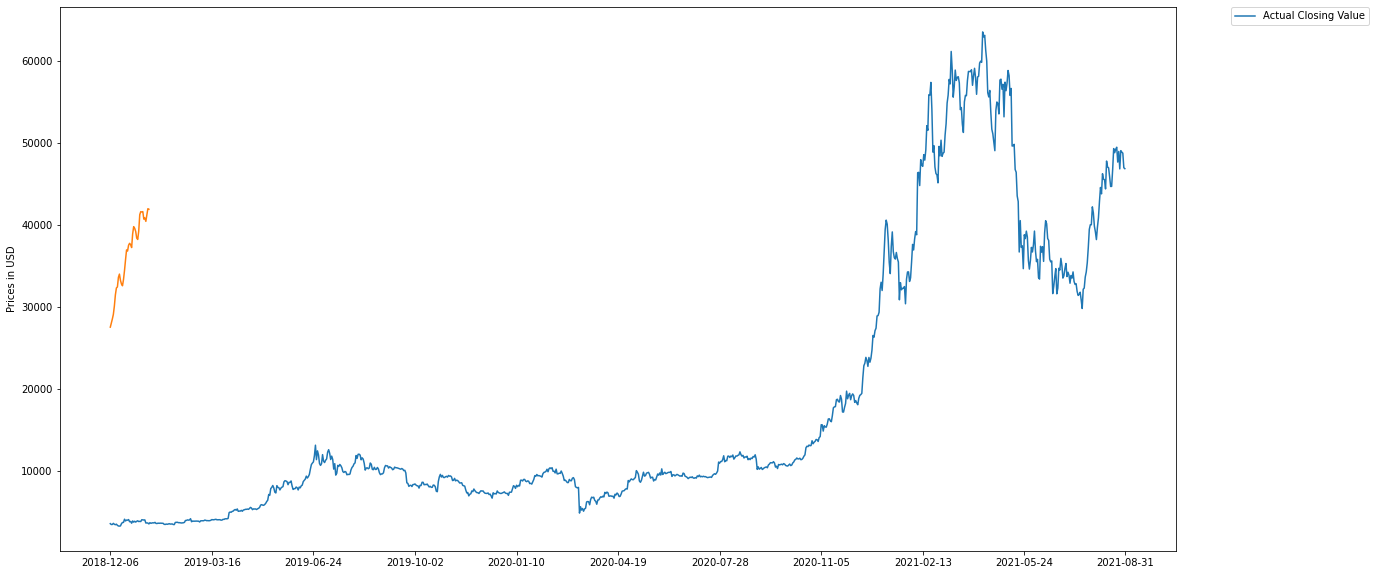

In [65]:


# plot baseline and predictions
fig, ax = plt.subplots(figsize=(20, 10))

plt.plot(scaler.inverse_transform(dataset), label="Actual Closing Value")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.plot(future_predict, label = "Future Predicted Values")
plt.ylabel('Prices in USD')
  
plt.xticks([0,100, 200, 300, 400, 500, 600, 700, 800, 900, 999],dates)
plt.show()